### QPE for Spin Heisenberg lattice
Exchange packages Qiskit to QLM to Cirq

In this notebook, we will show how we can use a tutorial provided by Devesh and Aman Gupta about QPE and performing exchange packages on this concept.

https://darveshiyat.medium.com/implementing-quantum-phase-estimation-algorithm-using-qiskit-e808e8167d32 

In exchange packages we will transform ciruits from qiskit to qlm to cirq and calculate the same eigenvalue in the 3 languages.

### Outline
<ol>
    <li>Energy calculation using Qiskit</li>
    <li>Energy calculation using QLM</li>
    <li>Energy calculation using Cirq</li>
    <li>Conclusion</li>
    <li>References</li>
</ol>

### Energy calculation using qiskit
<hr>

In [34]:
from qiskit import *
#from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.circuit.library import QFT

First, a function to transform the operator we want to find its eigenvalue into a quantum gate is built.

In [35]:
def qc(operator):
    qubit_list = list(range(int(np.log(len(operator))
                                /np.log(2)))) #extract the no. of qubits req. in circuit 
    qc = QuantumCircuit(len(qubit_list))
    qc.unitary(operator,qubit_list)
    return qc

Before going on, it is worth explaining how QPE works:

<ol>
    <li>Controlls of the operator gate are performed</li>
    <li>Inverse QFT is performed</li>
</ol>

In [14]:
def my_qpe(w_qubits,s_qubits, gate, initial_state = None, trotter_number = 1):  
    repetitions=1
    #defining a qpe circuit
    qpe_0 = QuantumCircuit(w_qubits+s_qubits,w_qubits)
    if (initial_state.all() != None):
        #initializing the state
        qpe_0.initialize(initial_state,list(range(w_qubits,w_qubits+s_qubits))) 
    for i in range(w_qubits):
        qpe_0.h(i)
    #to perform trotterization
    for j in range(trotter_number): 
        for counting_qubit in range(w_qubits):
            #to perform U^k operations where k is repetitions
            for i in range(repetitions):
                qubit_list = [counting_qubit]+list(range(w_qubits,w_qubits+s_qubits))
                qpe_0.append(gate,qubit_list)
            repetitions *= 2
        repetitions = 1
    #used inbuilt qft to perform inverse qft and implemented swap 
    qpe_1 = QFT(w_qubits, 0, True , True)
    l = [*range(w_qubits)]
    #finally composed qpe0 and inverse qft 
    qpe = qpe_0.compose(qpe_1, l)
    return qpe

A function to find and plot the eigenvalue.

In [36]:
def plot_to_eigenval(count,t,n=1):
    w_qubits = len(list(count.keys())[0])
    list_ = []
    #if time step is zero then phase cannot be determined hence return a default 0
    if t == 0: 
        display(0)
    else:
        #will choose n maximum count values
        lists = sorted(count, key=count.get, reverse=True)[:n] 
        for j in range(len(lists)):
            #convert those binary keys into decimal
            lists[j] =  int(str(lists[j]), 2) 
        for j in range(len(lists)):
            #for positive eigenvalues choose this equation
            list_.append((2*pi*(2**w_qubits - lists[j]))/((2**w_qubits)*t))
            # if it is negative then choose this value
            lists[j] = -2*pi*(lists[j])/((2**w_qubits)*t) 
        return lists,list_

The ising hamiltnian to simulate is

$H$ = $0.33$*$Z_{0}$ + $3.24$*$Z_{1}$ + $1.17$$Z_{0}Z_{1}$

In [37]:
import numpy as np
from qiskit.opflow import X,Y,Z,I,CX
pi = np.pi
sin = np.sin
cos = np.cos
exp = np.exp

# taking no. of trotter step = 1, as all the operators in H commutes in this case.
trotter_number = 2
t = 1 # delta t, time
H = (0.33*t/trotter_number*Z^I)+(3.24*t/trotter_number*I^Z)+(1.17*t/trotter_number*Z^Z)
U = H.exp_i() #obtaining the evolution operator for H with t = 1
U = U.to_matrix()

Now we run the circuit and calculate the eigenvalue.

C:\Users\husse\anaconda3\envs\openvqeQAOA\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


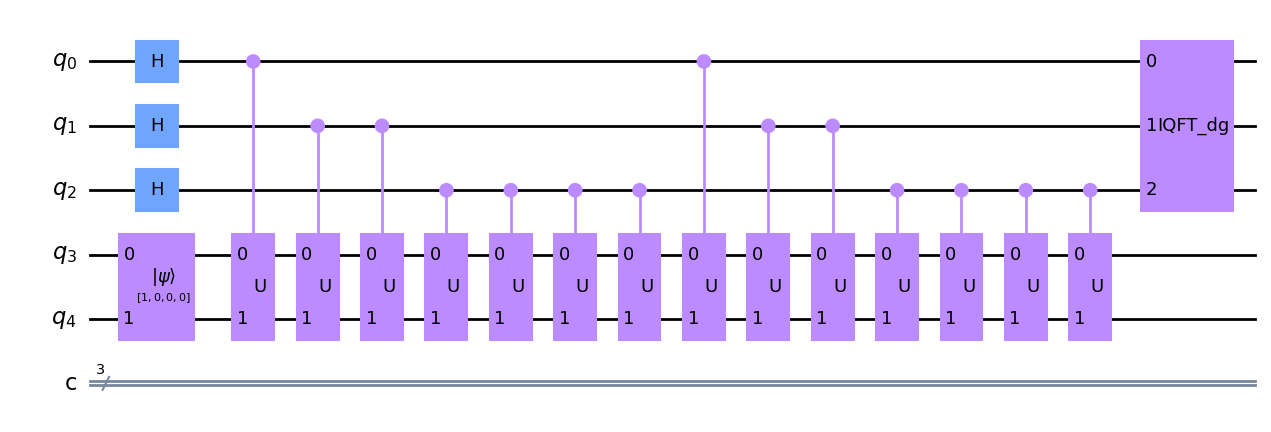

C:\Users\husse\AppData\Local\Temp\ipykernel_5516\2116444667.py:14: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  result = execute(qpe, backend = simulator, shots = 8192).result()


Energy eigenvalue for state v[0] is = 4.71238898038469


In [38]:
w_qubits = 3
s_qubits = 2
#defining intial state of system
initial_state = np.array([1, 0, 0, 0])
#defining evolution gate(U = e^{iHt}) for H
U_gate = qc(U).to_gate(label = 'U').control(1)
qpe = my_qpe(w_qubits,s_qubits, U_gate, 
             initial_state = initial_state,trotter_number = trotter_number)
display(qpe.draw('mpl'))

qpe.measure([0,1,2],[0,1,2])

simulator = Aer.get_backend('qasm_simulator')
result = execute(qpe, backend = simulator, shots = 8192).result()
count = result.get_counts(qpe)
print('Energy eigenvalue for state v[0] is =', plot_to_eigenval(count,t = 1)[1][0])

### Energy calculation using QLM
<hr>

Not all gates are supported by QLM, so we change the gates in the circuit into basis gates supported by QLM.

In [40]:
from qiskit.compiler import transpile

basis_gates = ['rx', 'u2', 'cx', 'ry', 'h', 'rz', 'P']

qc_trans = transpile(qpe, basis_gates=basis_gates)
#qc_trans.draw()

We now change the circuit from qiskit to QLM circuit.

In [41]:
from qat.lang import *
from qat import *
from qat.interop.qiskit import qiskit_to_qlm

qlm_circuit = qiskit_to_qlm(qc_trans)

The next step is simply finding the measured bit string that has the highest probability.

In [42]:
from qat.qpus import get_default_qpu

job = qlm_circuit.to_job(nbshots=100)

# Execute
result = get_default_qpu().submit(job)
for sample in result:
    print("State %s: probability %s +/- %s" % (sample.state, sample.probability, sample.err))

State |01000>: probability 0.99 +/- 0.010000000000000005
State |10100>: probability 0.01 +/- 0.01


The string '00010' had the highest probability.

In [43]:
value_sampled = int('00010', 2)

After transforming this string into an int, we use the following equation and we can clearly see that we got the same value as in qiskit.

In [44]:
2*pi*(2**w_qubits - value_sampled)/((2**w_qubits)*t)

4.71238898038469

### Energy calculation using cirq
<hr>

First, we transform the QLM circuit into a cirq circuit.

In [45]:
from qat.interop.cirq import qlm_to_cirq
cirq_circuit = qlm_to_cirq(qlm_circuit)

We have 2 ways to get the resulting bit string, in the first example we use the following cell, we can see that we got the following string which is '01000', we might notice that it is different from that of qiskit, mainly reversed and that is normal since qiskit reads the string in reverse, so it should be reversed, '00010', so we get the same string.

In [47]:
s = cirq.Simulator()

print('Simulate the circuit:')
results = s.simulate(cirq_circuit)
print(results)

Simulate the circuit:
measurements: q(1)=0 q(2)=1 q(3)=0 q(4)=0 q(5)=0

qubits: (cirq.LineQubit(1),)
output vector: |0⟩

qubits: (cirq.LineQubit(2),)
output vector: |1⟩

qubits: (cirq.LineQubit(3),)
output vector: |0⟩

qubits: (cirq.LineQubit(4),)
output vector: (-0.774+0.633j)|0⟩

qubits: (cirq.LineQubit(5),)
output vector: |0⟩

phase:
output vector: |⟩


We now use 3 qubits to add measurements at the end of the circuit for the simulator to work and get the samples.

In [48]:
import cirq
q0, q1, q2 = cirq.LineQubit.range(3)

We append measurementes to the end of the circuit using the newly defined qubits, q0, q1 and q2.

In [49]:
cirq_circuit.append(cirq.measure(q0, q1, q2, key='result'))

Now we use run instead of simulate.

In [50]:
samples = s.run(cirq_circuit, repetitions=1)

We can see that we get another time the correct bit string '00010', and we get it 2 times the same. We can of course specify the number of repetitions as we want. Here we defined above to repeat 1 extra time.

In [52]:
samples

q(1)=0
q(1)=0
q(2)=1
q(2)=1
q(3)=0
q(3)=0
q(4)=0
q(5)=0
result=0, 0, 1

### Conclusion
<hr>

We can clearly see that we were able to get the same measure bit string in the end using 3 different quantum programming languages. This shows the power of the MyQLM library and the concept of exchange packages.

### References
<hr>

<ol>
    <li>Qiskit Operators: <a href="https://qiskit-org-web-resources.s3.us.cloud-object-storage.appdomain.cloud/documentation/stable/0.19/tutorials/circuits_advanced/2_operators_overview.html">link</a></li>
    <li>Cirq Simulator: <a href="https://quantumai.google/cirq/simulate/simulation">link</a></li>
    <li>MyQLM Documentation: <a href="https://myqlm.github.io/01_getting_started/%3Amyqlm%3A01_install.html">link</a></li>
</ol>